In [2]:
import pandas as pd
import numpy as np
from itertools import product

import oracles
import optimization
from optimization import gradient_descent, newton

In [3]:
!wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a
!wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/gisette_scale.bz2
!wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/real-sim.bz2
!wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/news20.binary.bz2
!wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/rcv1_train.binary.bz2
!bzip2 -d gisette_scale.bz2
!bzip2 -d real-sim.bz2
!bzip2 -d news20.binary.bz2
!bzip2 -d rcv1_train.binary.bz2

--2022-03-01 12:57:32--  https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3478238 (3.3M)
Saving to: ‘w8a.3’

w8a.3               100%[===================>]   3.32M  2.22MB/s    in 1.5s    

2022-03-01 12:57:35 (2.22 MB/s) - ‘w8a.3’ saved [3478238/3478238]

--2022-03-01 12:57:35--  https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/gisette_scale.bz2
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21902461 (21M) [application/x-bzip2]
Saving to: ‘gisette_scale.bz2.2’

gisette_scale.bz2.2 100%[===================>]  20.89M  7.72MB/s    in 2.7s    

2022-03-01 12:57:38 (7.72 MB/s) - ‘gisett

In [4]:
from joblib import Memory
from sklearn.datasets import load_svmlight_file
mem = Memory("./mycache")

data = ["w8a", "gisette_scale", "real-sim", "news20.binary", "rcv1_train.binary"]

@mem.cache
def get_data(name):
    data = load_svmlight_file(name)
    return data[0], data[1]

for d in data:
    X, y = get_data(d)
    display(X)

<49749x300 sparse matrix of type '<class 'numpy.float64'>'
	with 579586 stored elements in Compressed Sparse Row format>

<6000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 29729997 stored elements in Compressed Sparse Row format>

<72309x20958 sparse matrix of type '<class 'numpy.float64'>'
	with 3709083 stored elements in Compressed Sparse Row format>

<19996x1355191 sparse matrix of type '<class 'numpy.float64'>'
	with 9097916 stored elements in Compressed Sparse Row format>

<20242x47236 sparse matrix of type '<class 'numpy.float64'>'
	with 1498952 stored elements in Compressed Sparse Row format>

In [6]:
for d in data:
    X, y = get_data(d)
    print(d, ": ", X.shape, sep='')

w8a: (49749, 300)
gisette_scale: (6000, 5000)
real-sim: (72309, 20958)
news20.binary: (19996, 1355191)
rcv1_train.binary: (20242, 47236)


In [9]:
import matplotlib.pyplot as plt 

def process(X, y, dataset, i):
  colors=['green', 'purple']
  oracle = oracles.create_log_reg_oracle(X, y, 1. / X.shape[1])
  x_0 = np.zeros(X.shape[1])
  iter_methods = ["Wolfe", "Armijo", "Constant"]
  for method in iter_methods:
    i += 1
    x_opt, message, history = gradient_descent(oracle, x_0, 
                                               line_search_options={'method': method}, trace=True)
    
    x_opt1, message1, history1 = newton(oracle, x_0, 
                                               line_search_options={'method': method}, trace=True)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(history['func'], label="Градиентный спуск", color=colors[0])
    ax.plot(history1['func'], label="Ньютон", color=colors[1])
    lab = 'Зависимость значения функции против номера итерации метода, метод ' + method
    plt.xlabel('Итерация', fontsize=15)
    plt.ylabel('Значение функции', fontsize=15)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(lab, fontsize=15)

    ax.legend()
    ax.grid()
    name = "4_1" + str(i)
    plt.savefig(name, bbox_inches="tight")
    plt.show()

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(history['time'], history['func'], label="Градиентный спуск", color=colors[0])
    ax.plot(history1['time'], history1['func'], label="Ньютон", color=colors[1])

    lab = 'Зависимость значения функции против реального времени работы, метод ' + method
    plt.xlabel('Время (секунды)', fontsize=15)
    plt.ylabel('Значение функции', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(lab, fontsize=15)

    ax.legend()
    ax.grid()
    name = "4_2" + str(i)
    plt.savefig(name, bbox_inches="tight")
    plt.show()

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(history['time'], (history['grad_norm'] / history['grad_norm'][0])**2, 
            label="Градиентный спуск", color=colors[0])
    
    ax.plot(history1['time'], (history1['grad_norm'] / history1['grad_norm'][0])**2, 
            label="Ньютон", color=colors[1]) 
       
    lab = 'Зависимость относительного квадрата нормы градиента против реального времени работы, метод ' + method
    plt.xlabel('Время (секунды)', fontsize=15)
    plt.xlabel('Время (секунды)', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel('Логарифм относительного квадрата нормы', fontsize=15)
    plt.yscale('log')
    plt.title(lab, fontsize=15)

    ax.legend(fontsize=12)
    ax.grid()
    name = "4_3" + str(i)
    plt.savefig(name, bbox_inches="tight")
    plt.show()


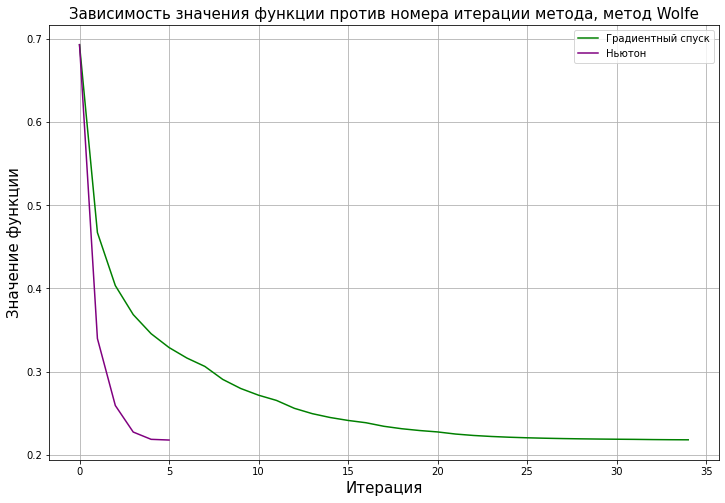

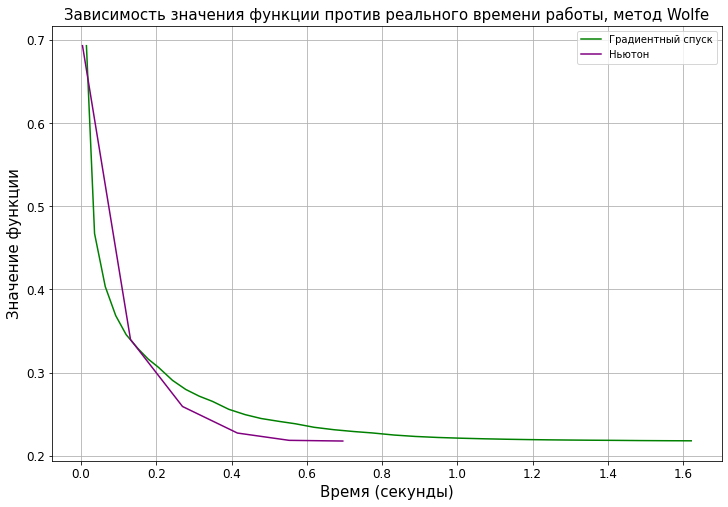

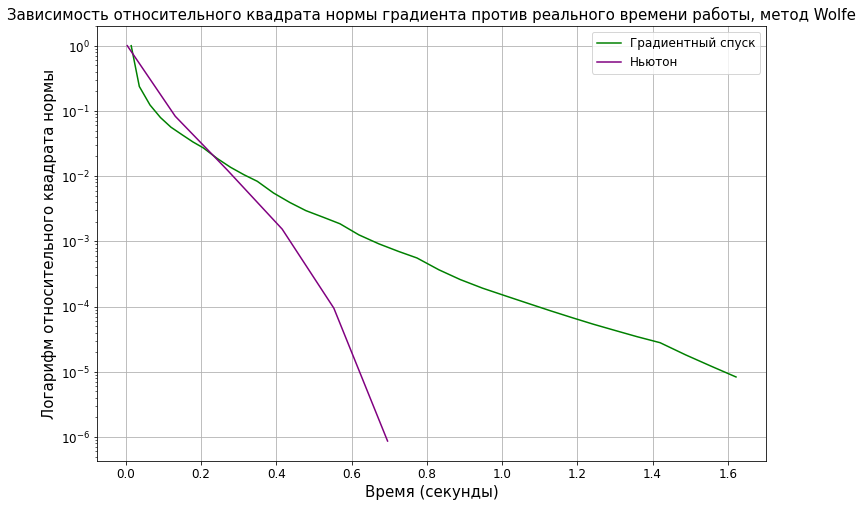

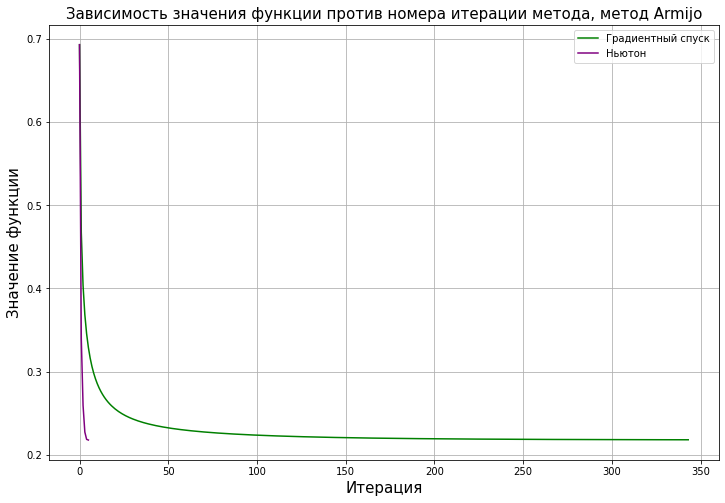

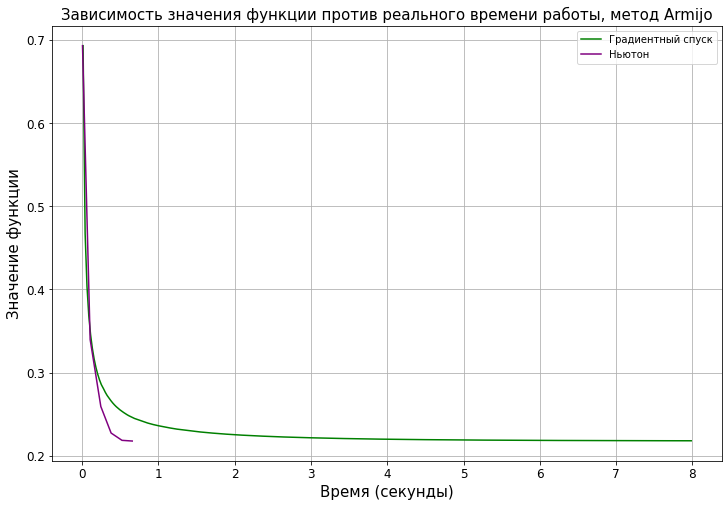

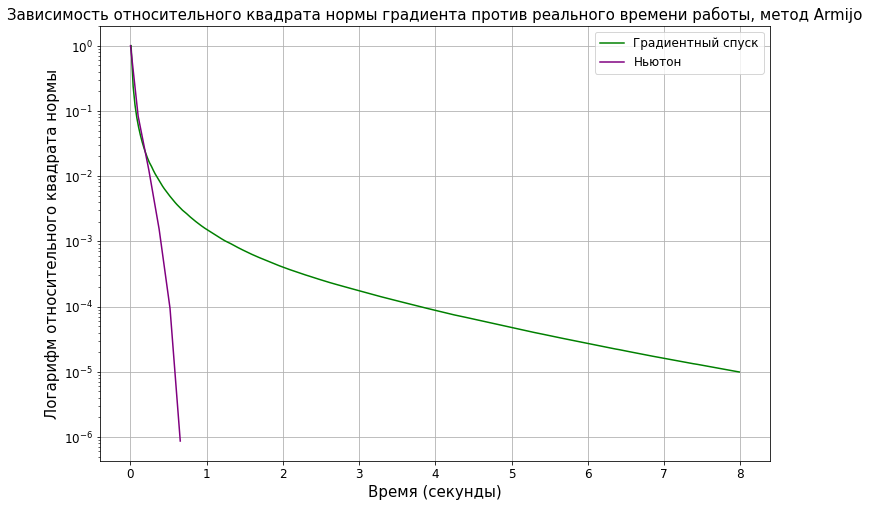

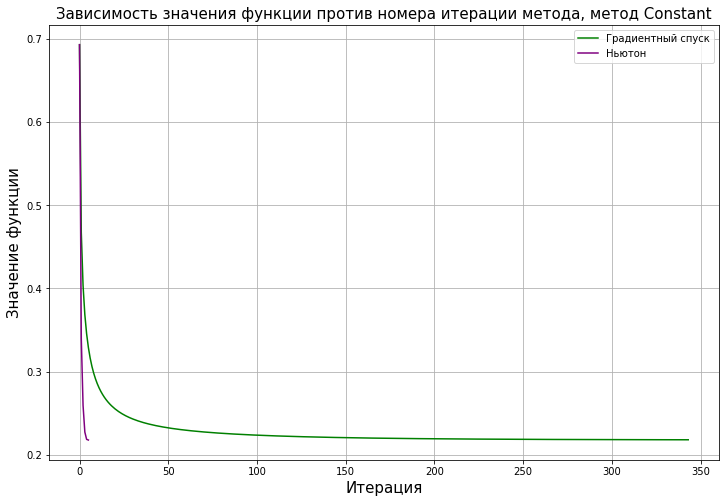

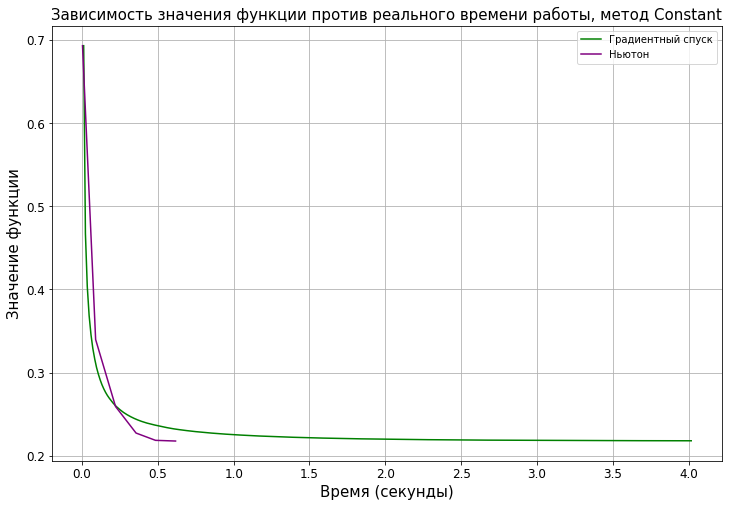

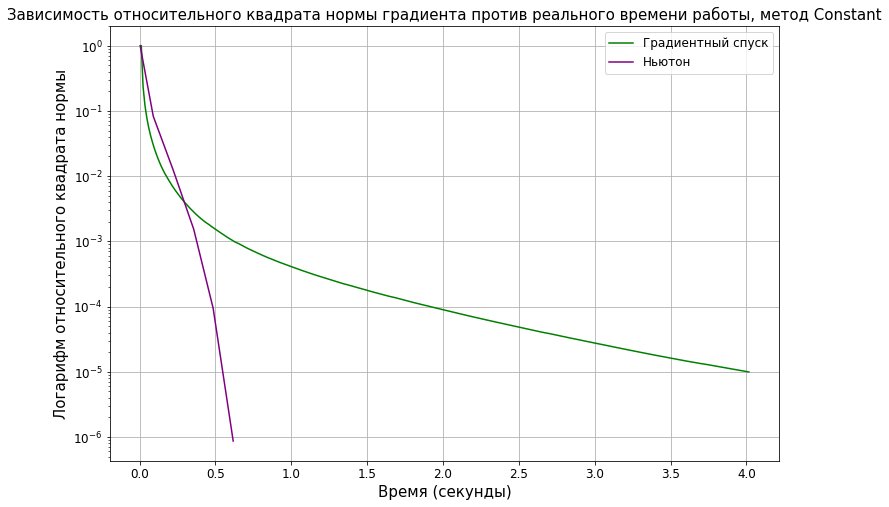

In [5]:
X, y = get_data("w8a")
process(X, y, "w8a", i=0)

In [13]:
def process_gd(X, y, dataset, i):
  colors=['green', 'purple']
  oracle = oracles.create_log_reg_oracle(X, y, 1. / X.shape[1])
  x_0 = np.zeros(X.shape[1])
  iter_methods = ["Wolfe", "Armijo", "Constant"]
  for method in iter_methods:
    i += 1
    x_opt, message, history = gradient_descent(oracle, x_0, 
                                               line_search_options={'method': method}, trace=True)
        
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(history['func'], label="Градиентный спуск", color=colors[0])
    lab = 'Зависимость значения функции против номера итерации метода, стратегия ' + str(method), 
    plt.xlabel('Итерация', fontsize=15)
    plt.ylabel('Значение функции', fontsize=15)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(lab, fontsize=15)

    ax.legend()
    ax.grid()
    name = "gd1_" + str(i)
    plt.savefig(name, bbox_inches="tight")
    plt.show()

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(history['time'], history['func'], label="Градиентный спуск", color=colors[0])

    lab = 'Зависимость значения функции против реального времени работы, стратегия ' + str(method)
    plt.xlabel('Время (секунды)', fontsize=15)
    plt.ylabel('Значение функции', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(lab, fontsize=15)

    ax.legend()
    ax.grid()
    name = "gd2_" + str(i)
    plt.savefig(name, bbox_inches="tight")
    plt.show()

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(history['time'], (history['grad_norm'] / history['grad_norm'][0])**2, 
            label="Градиентный спуск", color=colors[0])
           
    lab = 'Зависимость относительного квадрата нормы градиента против реального времени работы, стратегия ' + str(method)
    plt.xlabel('Время (секунды)', fontsize=15)
    plt.xlabel('Время (секунды)', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel('Логарифм относительного квадрата нормы', fontsize=15)
    plt.yscale('log')
    plt.title(lab, fontsize=15)

    ax.legend(fontsize=12)
    ax.grid()
    name = "gd3_" + str(i)
    plt.savefig(name, bbox_inches="tight")
    plt.show()

In [ ]:
data = ["w8a", "gisette_scale", "real-sim", "news20.binary", "rcv1_train.binary"]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


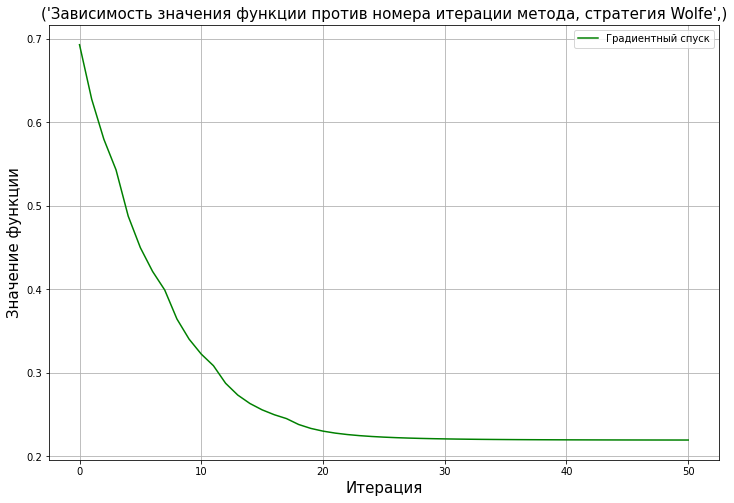

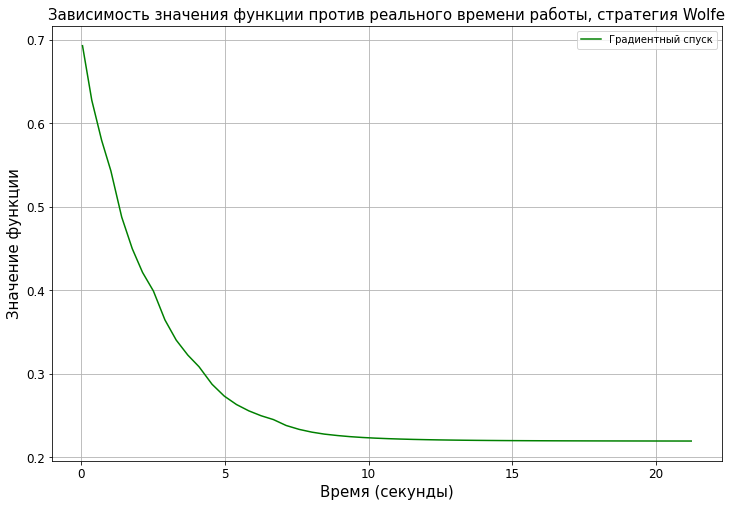

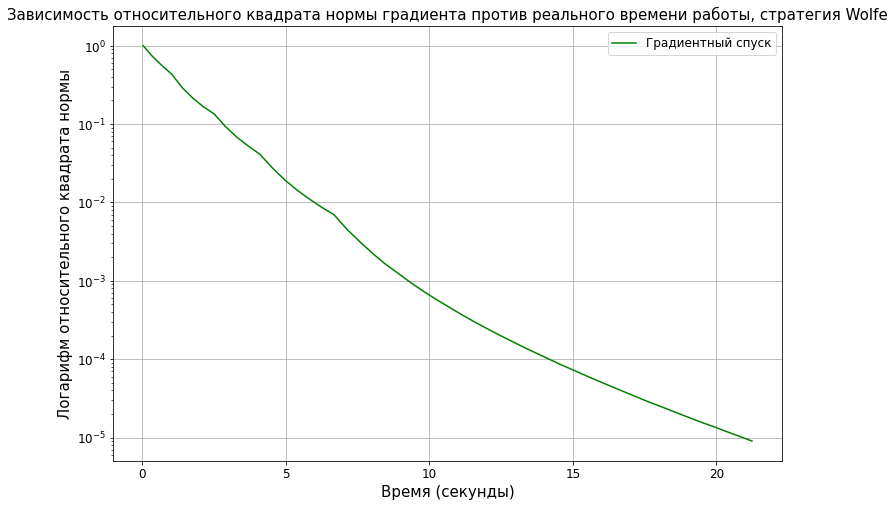

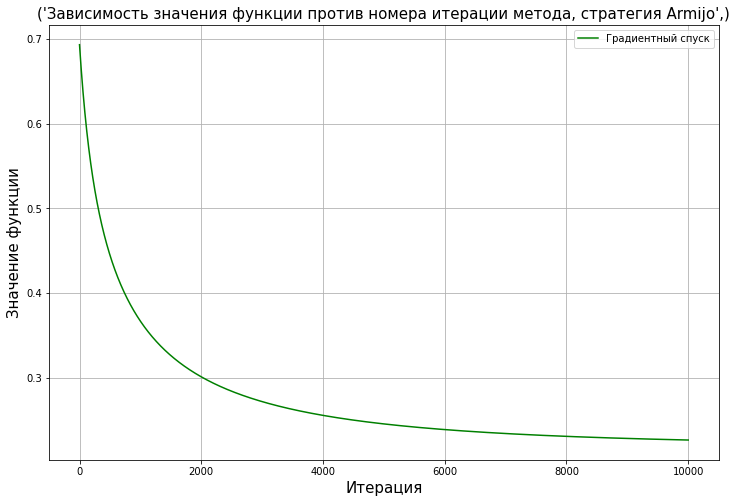

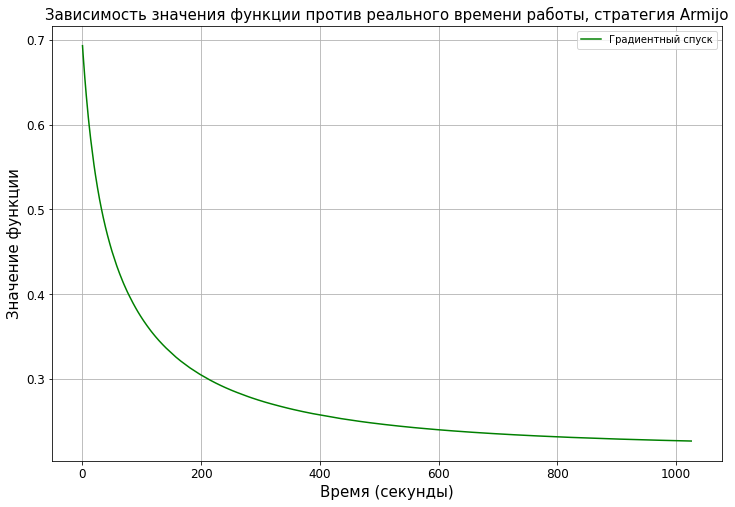

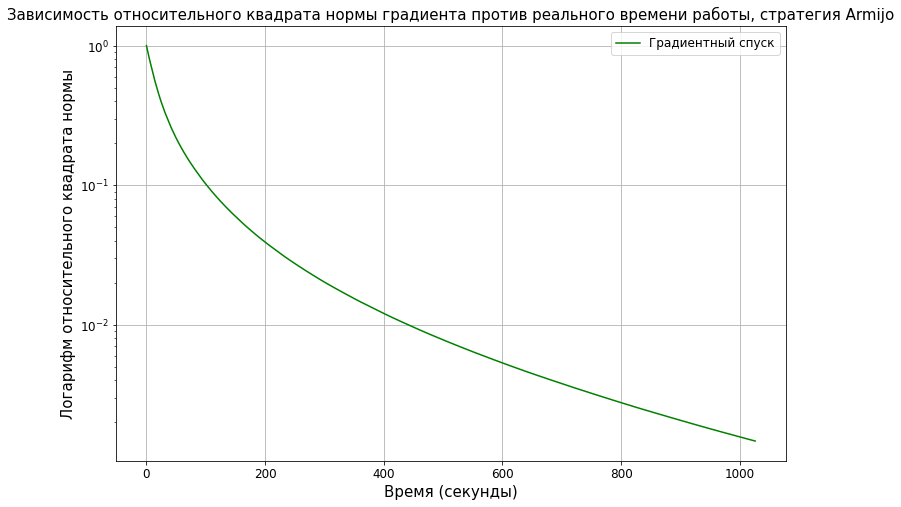

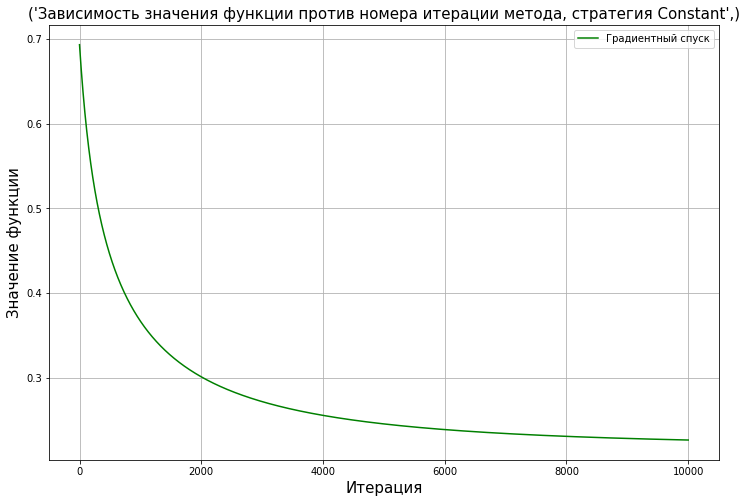

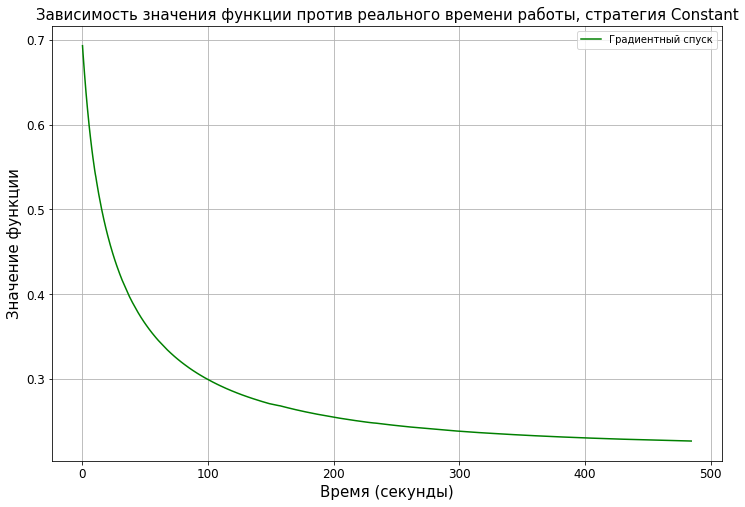

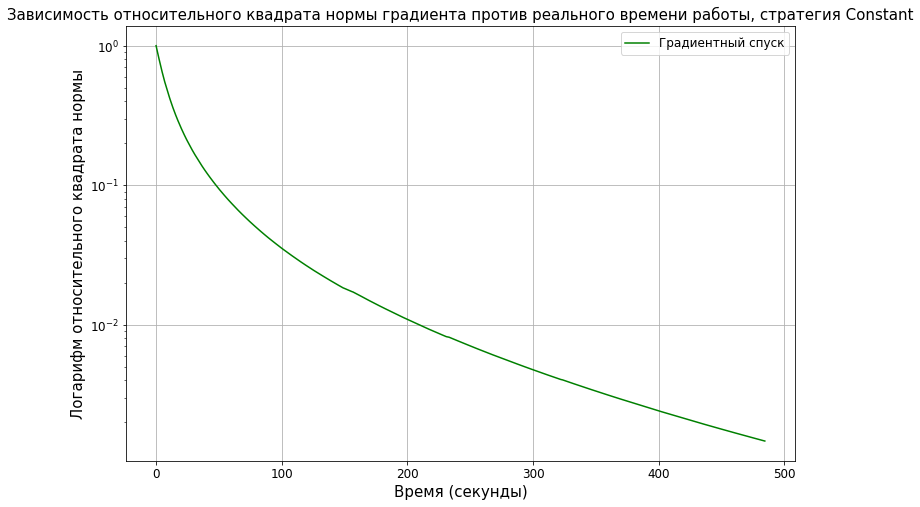

In [14]:
X, y = get_data("real-sim")
process_gd(X, y, "real-sim", i=0)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


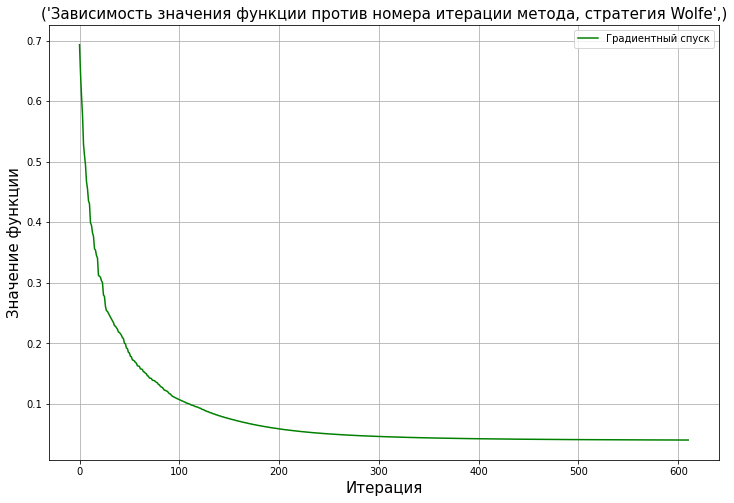

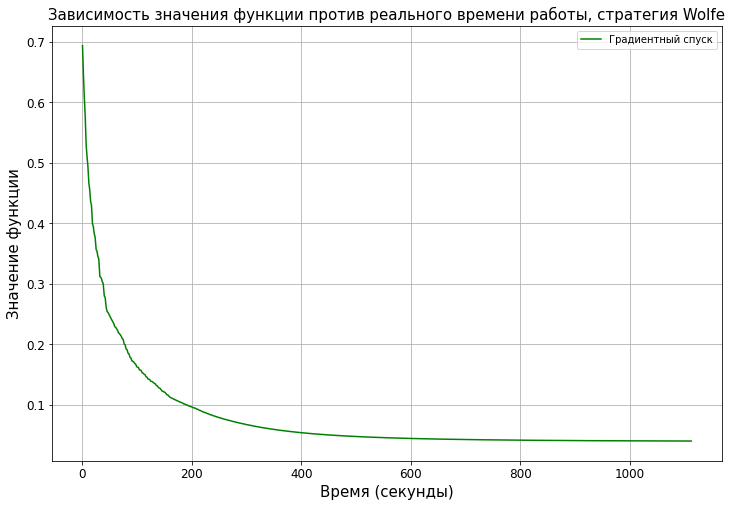

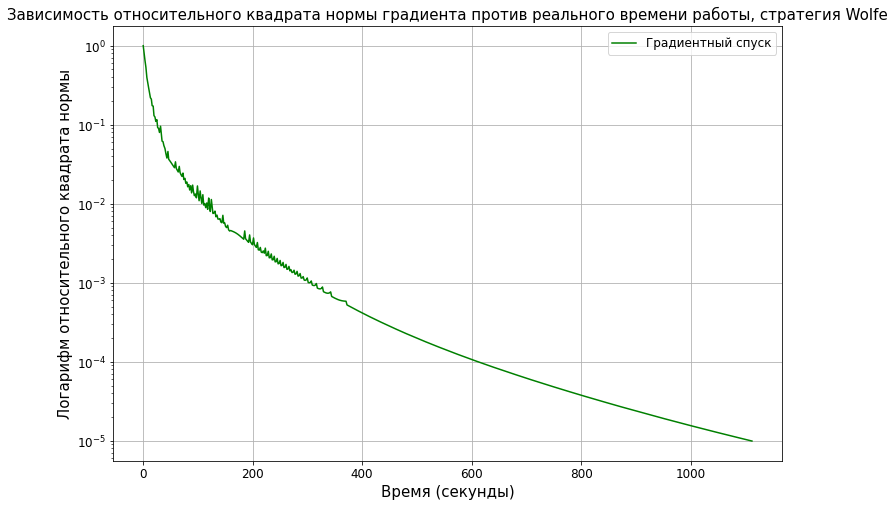

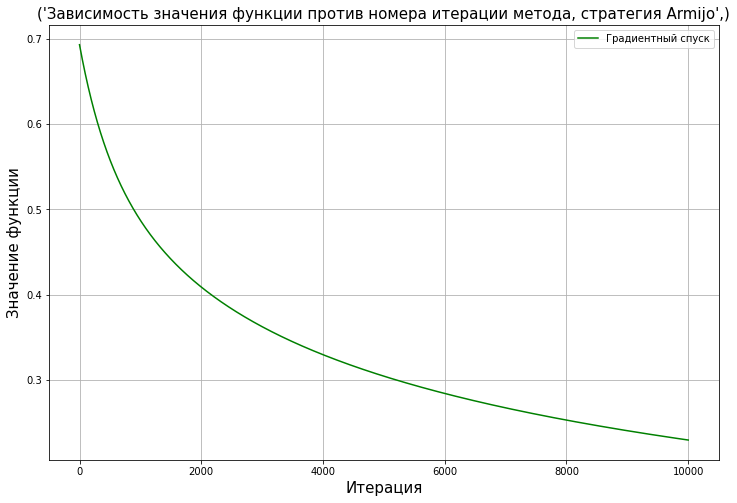

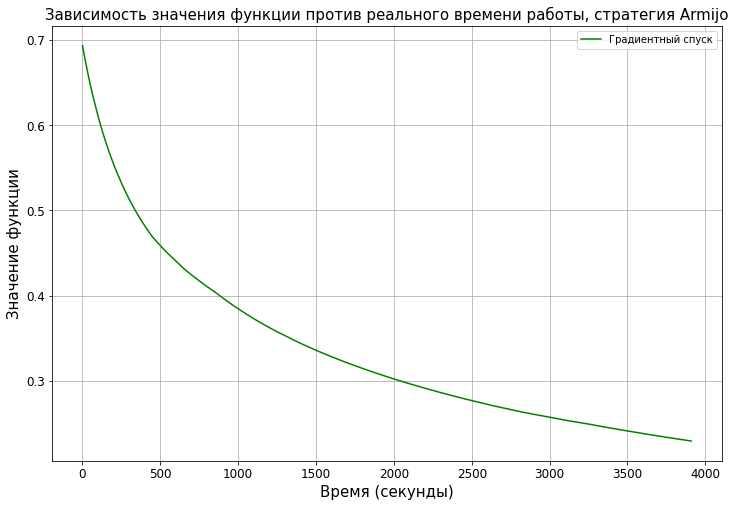

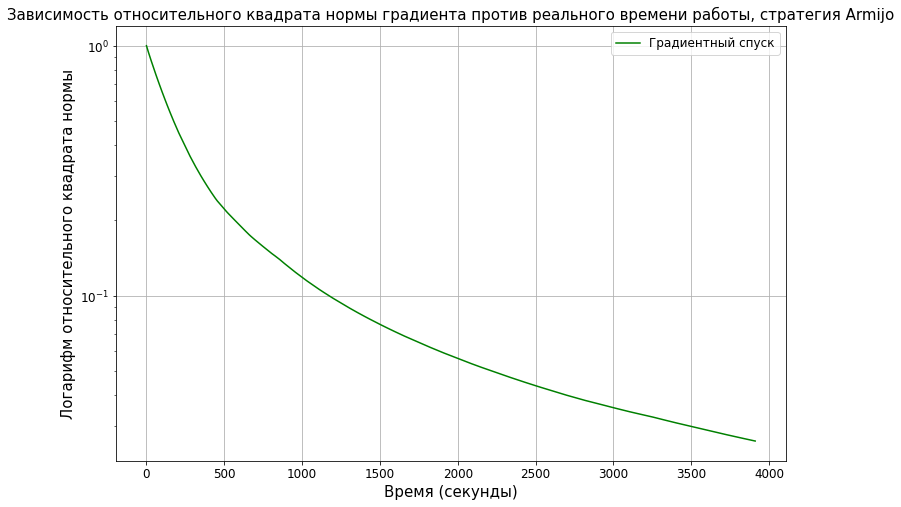

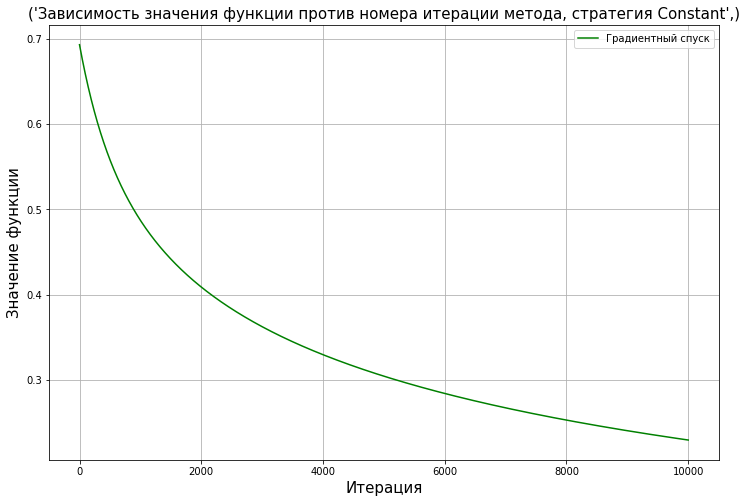

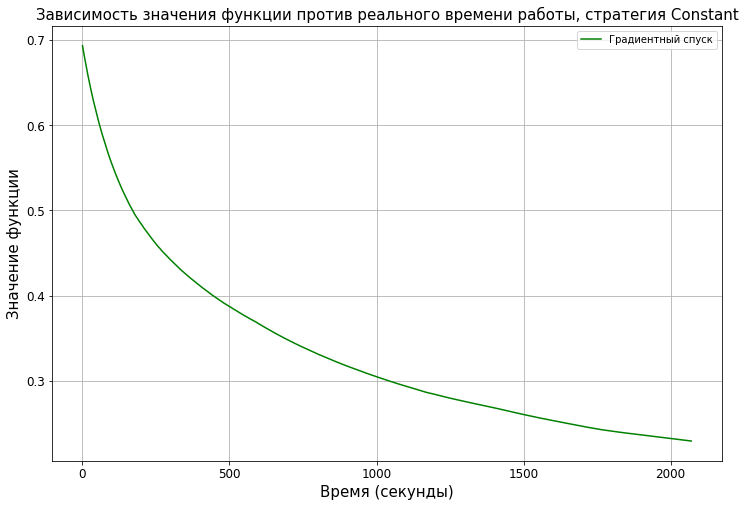

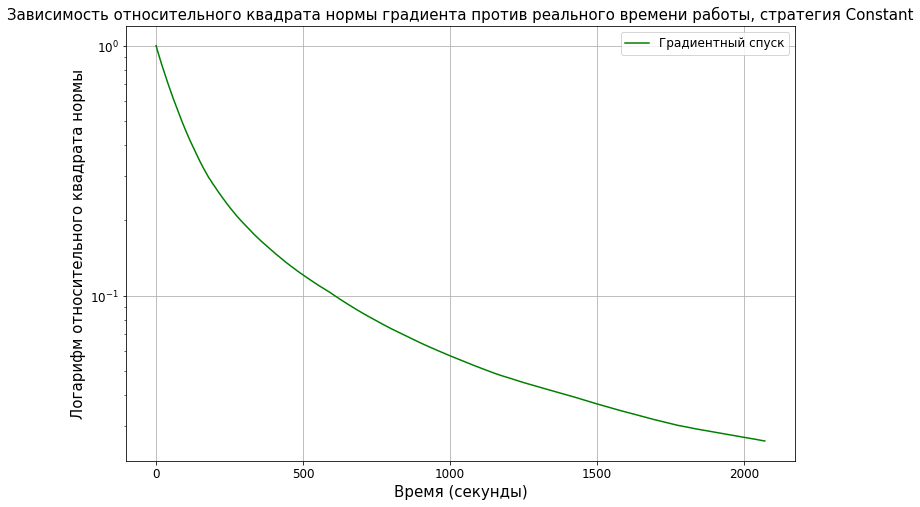

In [ ]:
X, y = get_data("news20.binary")
process_gd(X, y, "news20.binary", i=4)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


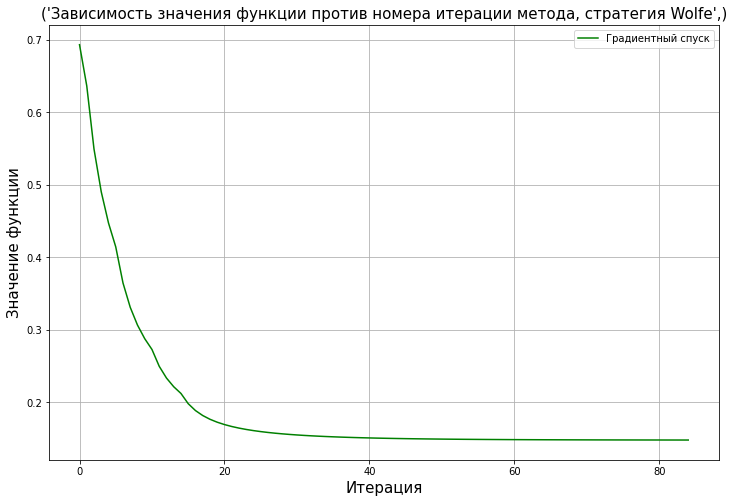

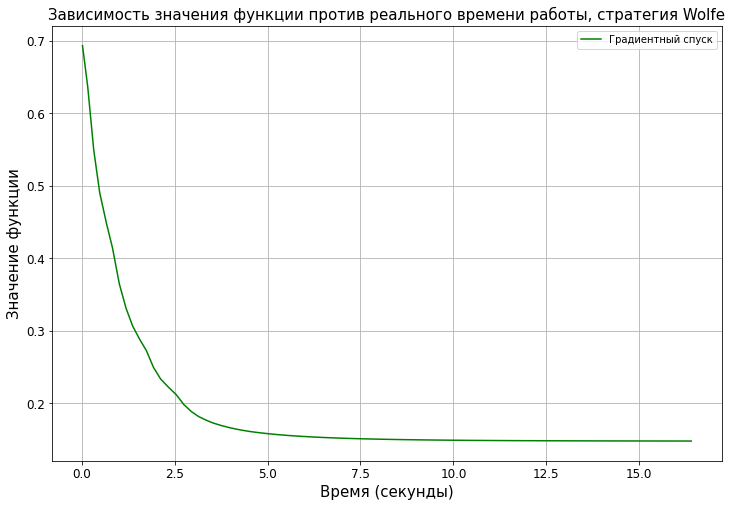

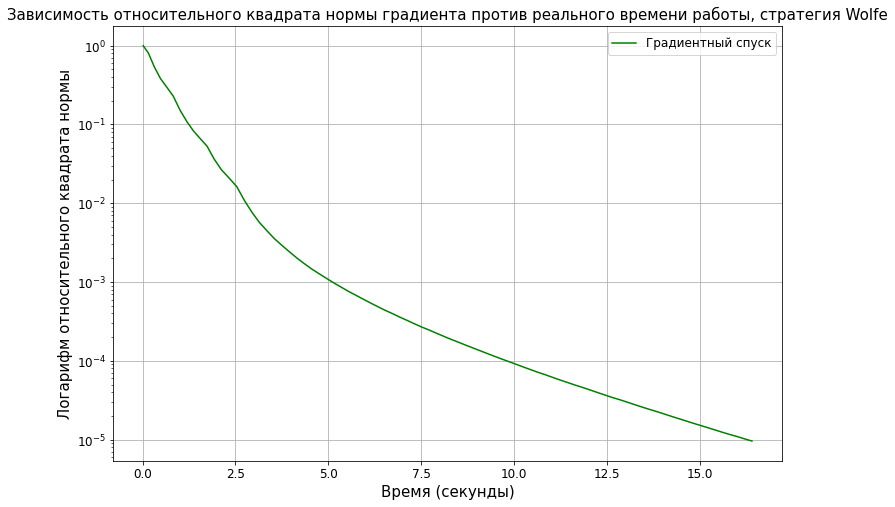

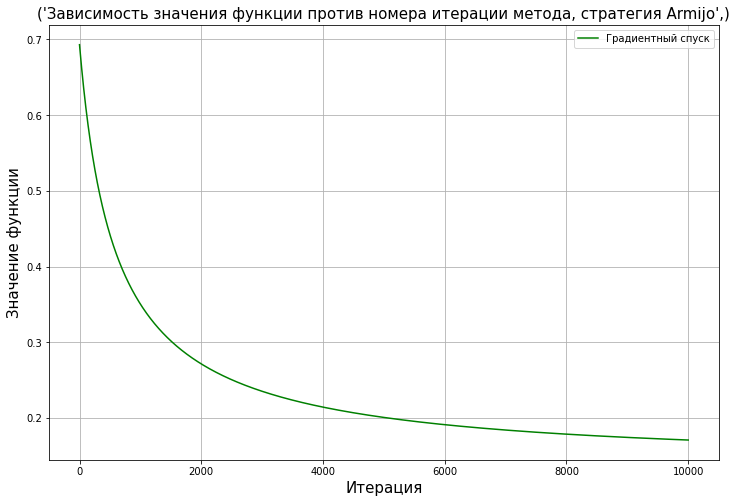

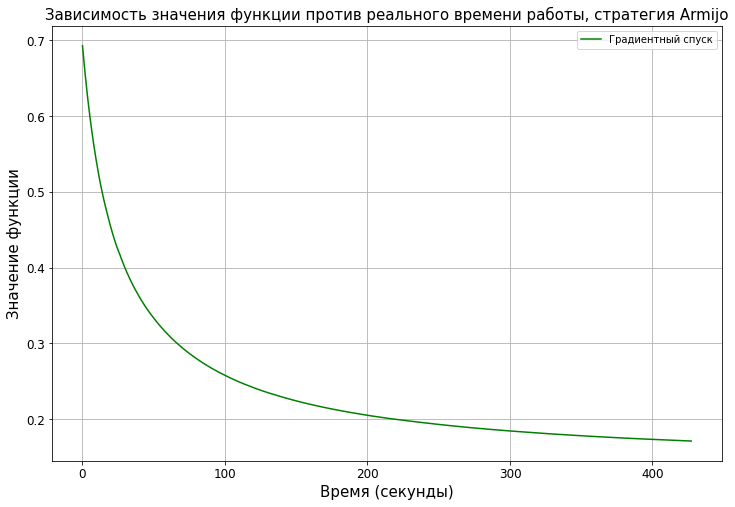

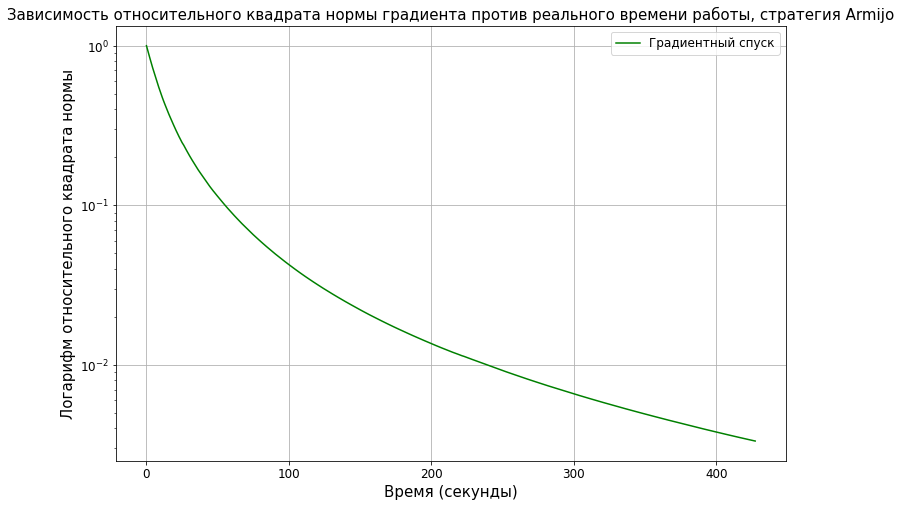

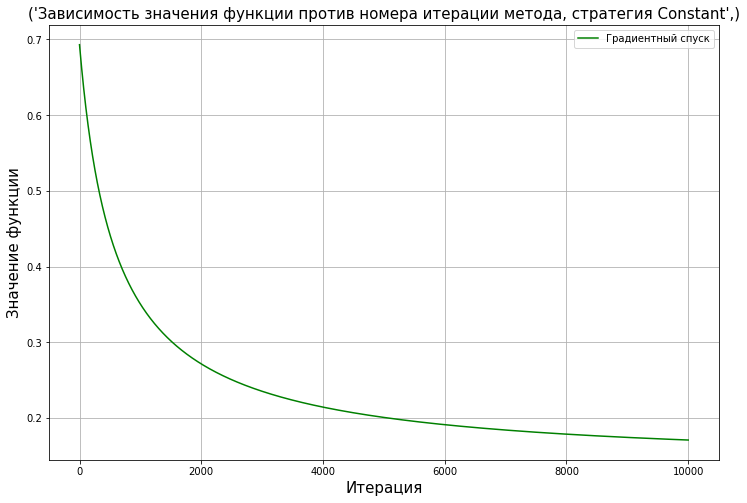

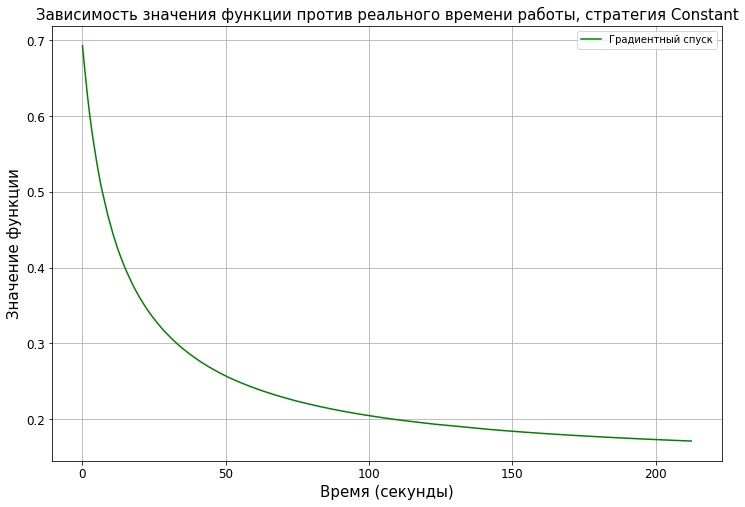

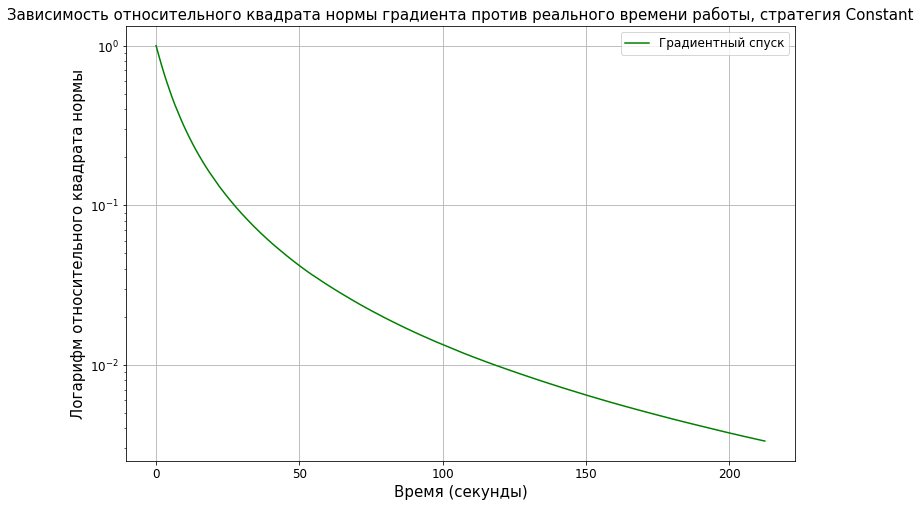

In [15]:
X, y = get_data("rcv1_train.binary")
process_gd(X, y, "rcv1_train.binary", i=7)